In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, mean_squared_error
from sklearn.metrics import precision_recall_curve, average_precision_score


import nibabel as nib
from nilearn import maskers
from nilearn.plotting import plot_stat_map

import sys
sys.path.append('/home/jerjes/repos/neurovlm/src/neurovlm')

from neurovlm.data import fetch_data
from neurovlm.train import which_device

device = which_device()

# Load autoencoder

In [2]:
# Load data
data_dir = fetch_data()

# Load original neuro vectors
neuro_vectors = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=True
).to("cpu")

# Load trained autoencoder
autoencoder = torch.load(
   data_dir / "autoencoder_soft.pt", weights_only=False
).to(device)

/home/jerjes/repos/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data splits

In [3]:
# Using the same distribution as for training, maybe we should only care about test or val, will compute training just for reference
inds = torch.arange(len(neuro_vectors))
train_inds, test_inds = train_test_split(
    inds, train_size=0.8, random_state=0
)
test_inds, val_inds = train_test_split(
    test_inds, train_size=0.5, random_state=1
)

# Prepare data for evaluation 
neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.001] = 1.0

print(f"Train samples: {len(train_inds)}")
print(f"Test samples: {len(test_inds)}")
print(f"Validation samples: {len(val_inds)}")
print(f"Non-zero voxels per map (mean): {(neuro_vectors_bin > 0).sum(dim=1).float().mean():.1f}")

Train samples: 22480
Test samples: 2810
Validation samples: 2810
Non-zero voxels per map (mean): 4335.2


# Generate recons

In [4]:
# Generate reconstructions for all data splits
autoencoder.eval()
reconstructions = {}

with torch.no_grad():
    # Reconstruct train set -- could delete, don't think we need these
    train_data = neuro_vectors_bin[train_inds].to(device)
    train_recon = torch.sigmoid(autoencoder(train_data)).cpu()
    reconstructions['train'] = {
        'original': neuro_vectors_bin[train_inds],
        'reconstructed': train_recon,
        'indices': train_inds
    }
    
    # Reconstruct test set
    test_data = neuro_vectors_bin[test_inds].to(device)
    test_recon = torch.sigmoid(autoencoder(test_data)).cpu()
    reconstructions['test'] = {
        'original': neuro_vectors_bin[test_inds],
        'reconstructed': test_recon,
        'indices': test_inds
    }
    
    # Reconstruct validation set
    val_data = neuro_vectors_bin[val_inds].to(device)
    val_recon = torch.sigmoid(autoencoder(val_data)).cpu()
    reconstructions['val'] = {
        'original': neuro_vectors_bin[val_inds],
        'reconstructed': val_recon,
        'indices': val_inds
    }

print("Reconstructions generated for all splits")

Reconstructions generated for all splits


# Evaluate

In [5]:
# Metrics 
def compute_metrics(original, reconstructed):
    """Compute MSE and SSIM between original and reconstructed brain maps."""
    
    mse_scores = []
    ssim_scores = []
    
    # Convert to numpy for easier computation
    orig_np = original.numpy()
    recon_np = reconstructed.numpy()
    
    for i in range(len(orig_np)):
        # MSE computation
        mse = mean_squared_error(orig_np[i], recon_np[i])
        mse_scores.append(mse)
        
        # SSIM computation
        data_range = max(orig_np[i].max() - orig_np[i].min(),
                        recon_np[i].max() - recon_np[i].min())
        
        if data_range > 0:  # Avoid division by zero
            ssim_score = ssim(orig_np[i], recon_np[i], data_range=data_range)
        else:
            ssim_score = 1.0  # Perfect similarity 
        ssim_scores.append(ssim_score)
    
    return np.array(mse_scores), np.array(ssim_scores)

In [6]:
# Compute metrics for each split
metrics = {}

for split_name, data in reconstructions.items():
    print(f"Computing metrics for {split_name} set...")
    
    mse_scores, ssim_scores = compute_metrics(
        data['original'], 
        data['reconstructed']
    )
    
    metrics[split_name] = {
        'mse': mse_scores,
        'ssim': ssim_scores,
        'indices': data['indices']
    }
    
    print(f"  MSE: {mse_scores.mean():.6f} ± {mse_scores.std():.6f}")
    print(f"  SSIM: {ssim_scores.mean():.4f} ± {ssim_scores.std():.4f}")
    print()

Computing metrics for train set...
  MSE: 0.022792 ± 0.023969
  SSIM: 0.7511 ± 0.2312

Computing metrics for test set...
  MSE: 0.030623 ± 0.025856
  SSIM: 0.7343 ± 0.2330

Computing metrics for val set...
  MSE: 0.031154 ± 0.026683
  SSIM: 0.7306 ± 0.2353



In [25]:
# Precision analysis
def binary_classification_analysis(original, reconstructed, threshold=0.1):
    """
    Analyze autoencoder performance as binary voxel classification.
    
    Args:
        original: Ground truth brain maps (batch_size, n_voxels)
        reconstructed: Reconstructed brain maps (batch_size, n_voxels)
        threshold: Threshold for binary classification
    """
    
    # Flatten all samples
    orig_flat = original.numpy().flatten()
    recon_flat = reconstructed.numpy().flatten()
    
    # Ground truth
    y_true = (orig_flat > threshold).astype(int)

    # Predictions
    y_scores = np.clip(recon_flat, 0, 1) 
    y_pred = (y_scores > threshold).astype(int)
    

    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate classification rates
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate 
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate 
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # AUC scores (if both classes present)
        if len(np.unique(y_true)) > 1:
            auc_roc = roc_auc_score(y_true, y_scores)
            auc_pr = average_precision_score(y_true, y_scores)
        else:
            auc_roc = auc_pr = np.nan
            
    else:
        # Handle edge case
        tpr = tnr = fpr = fnr = precision = auc_roc = auc_pr = np.nan
        tp = tn = fp = fn = 0
    
    return {
        'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr, 'precision': precision,
        'auc_roc': auc_roc, 'auc_pr': auc_pr,
        'confusion_matrix': cm,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'y_true': y_true, 'y_scores': y_scores, 'y_pred': y_pred,
        'n_active_voxels': np.sum(y_true),
        'n_total_voxels': len(y_true)
    }

In [26]:
# Analyze classification performance for each split
thresholds_to_test = [0.01, 0.05, 0.1, 0.5]
classification_results = {}

for split_name, data in reconstructions.items():
    if split_name == 'train': 
        continue
        
    print(f"\n=== {split_name.upper()} SET CLASSIFICATION ANALYSIS ===")
    
    split_results = {}
    
    for threshold in thresholds_to_test:
        result = binary_classification_analysis(
            data['original'], 
            data['reconstructed'], 
            threshold=threshold
        )
        split_results[threshold] = result
        
        print(f"\nThreshold = {threshold}")
        print(f"  TPR: {result['tpr']:.4f}")
        print(f"  TNR: {result['tnr']:.4f}")
        print(f"  FPR: {result['fpr']:.4f}")
        print(f"  FNR: {result['fnr']:.4f}")
        print(f"  Precision: {result['precision']:.4f}")
        print(f"  AUC-ROC: {result['auc_roc']:.4f}")
        
    classification_results[split_name] = split_results


=== TEST SET CLASSIFICATION ANALYSIS ===

Threshold = 0.01
  TPR (Sensitivity): 0.9652
  TNR (Specificity): 0.8107
  FPR (False Alarm): 0.1893
  FNR (Miss Rate):   0.0348
  Precision:         0.1984
  AUC-ROC:          0.9556

Threshold = 0.05
  TPR (Sensitivity): 0.8779
  TNR (Specificity): 0.8930
  FPR (False Alarm): 0.1070
  FNR (Miss Rate):   0.1221
  Precision:         0.2848
  AUC-ROC:          0.9556

Threshold = 0.1
  TPR (Sensitivity): 0.7960
  TNR (Specificity): 0.9266
  FPR (False Alarm): 0.0734
  FNR (Miss Rate):   0.2040
  Precision:         0.3448
  AUC-ROC:          0.9556

Threshold = 0.5
  TPR (Sensitivity): 0.4187
  TNR (Specificity): 0.9852
  FPR (False Alarm): 0.0148
  FNR (Miss Rate):   0.5813
  Precision:         0.5786
  AUC-ROC:          0.9556

=== VAL SET CLASSIFICATION ANALYSIS ===

Threshold = 0.01
  TPR (Sensitivity): 0.9658
  TNR (Specificity): 0.8080
  FPR (False Alarm): 0.1920
  FNR (Miss Rate):   0.0342
  Precision:         0.1982
  AUC-ROC:          0

# Summarize results

## Table

In [29]:
# Create summary statistics table
summary_stats = []

for split_name, split_metrics in metrics.items():
    summary_stats.extend([
        {
            'Split': split_name.capitalize(),
            'Metric': 'MSE',
            'Mean': split_metrics['mse'].mean(),
            'Std': split_metrics['mse'].std(),
            'Min': split_metrics['mse'].min(),
            'Max': split_metrics['mse'].max()
        },
        {
            'Split': split_name.capitalize(),
            'Metric': 'SSIM',
            'Mean': split_metrics['ssim'].mean(),
            'Std': split_metrics['ssim'].std(),
            'Min': split_metrics['ssim'].min(),
            'Max': split_metrics['ssim'].max()
        }
    ])

summary_df = pd.DataFrame(summary_stats)
print("Summary Statistics:")
print(summary_df.round(6))

Summary Statistics:
   Split Metric      Mean       Std       Min       Max
0  Train    MSE  0.022792  0.023969  0.000000  0.134118
1  Train   SSIM  0.751117  0.231227  0.056787  0.999264
2   Test    MSE  0.030623  0.025856  0.000000  0.140189
3   Test   SSIM  0.734340  0.233037  0.042820  0.999136
4    Val    MSE  0.031154  0.026683  0.000000  0.142835
5    Val   SSIM  0.730647  0.235275  0.053838  0.999755


## Figures

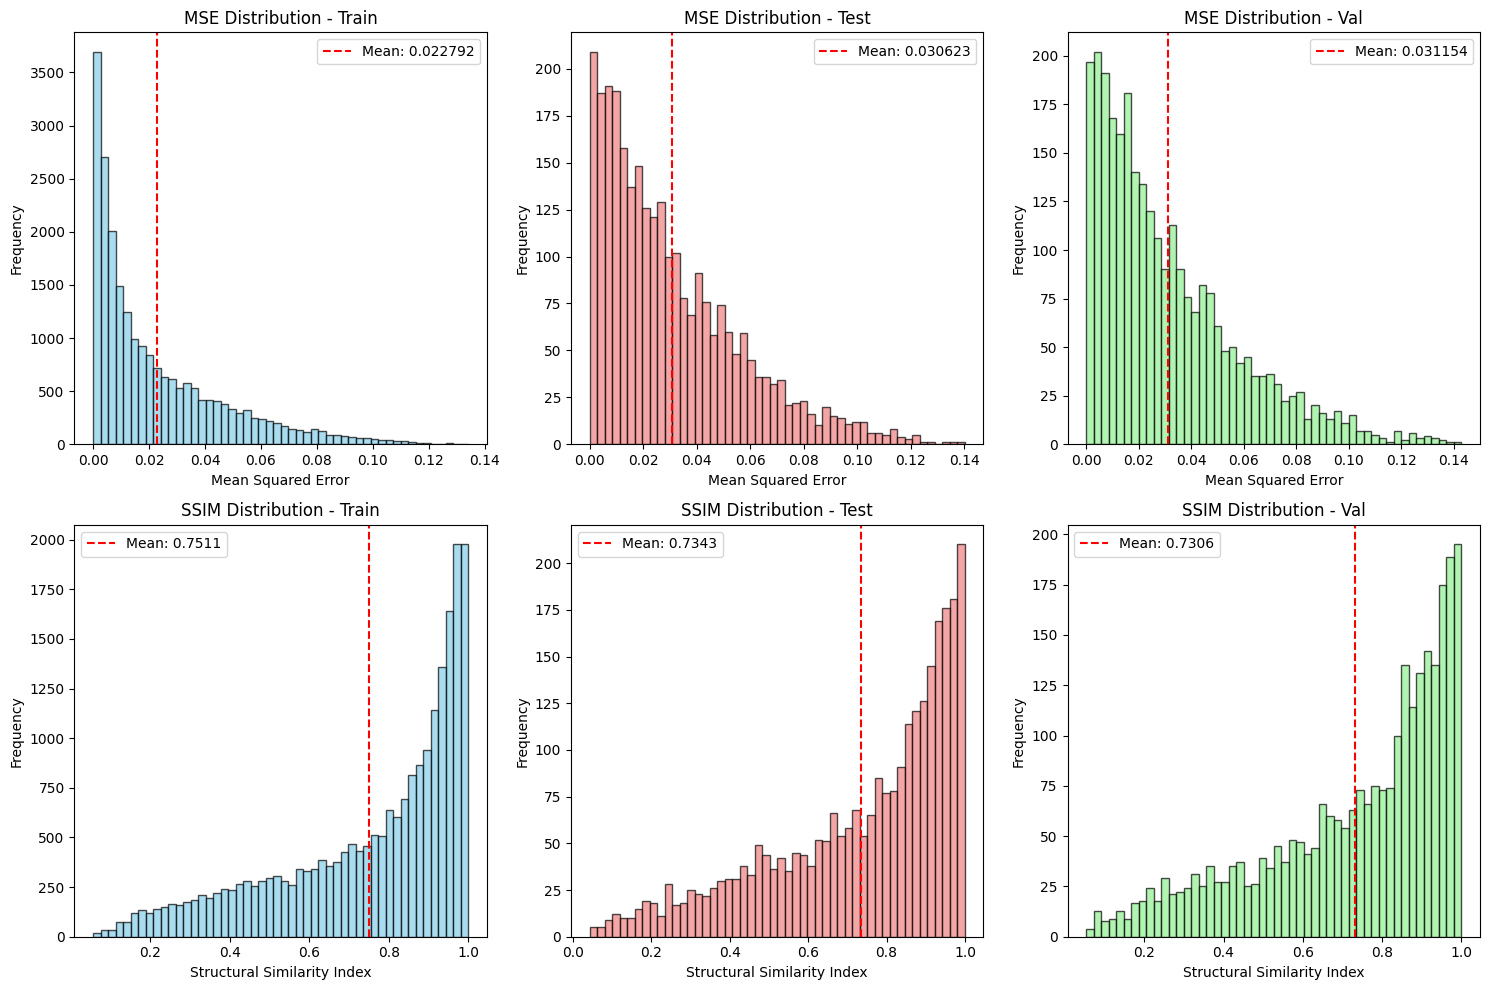

In [30]:
# Histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

splits = ['train', 'test', 'val']
colors = ['skyblue', 'lightcoral', 'lightgreen']

# MSE distributions
for i, (split, color) in enumerate(zip(splits, colors)):
    axes[0, i].hist(metrics[split]['mse'], bins=50, alpha=0.7, color=color, edgecolor='black')
    axes[0, i].set_title(f'MSE Distribution - {split.capitalize()}')
    axes[0, i].set_xlabel('Mean Squared Error')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].axvline(metrics[split]['mse'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {metrics[split]["mse"].mean():.6f}')
    axes[0, i].legend()

# SSIM distributions  
for i, (split, color) in enumerate(zip(splits, colors)):
    axes[1, i].hist(metrics[split]['ssim'], bins=50, alpha=0.7, color=color, edgecolor='black')
    axes[1, i].set_title(f'SSIM Distribution - {split.capitalize()}')
    axes[1, i].set_xlabel('Structural Similarity Index')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].axvline(metrics[split]['ssim'].mean(), color='red', linestyle='--',
                      label=f'Mean: {metrics[split]["ssim"].mean():.4f}')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

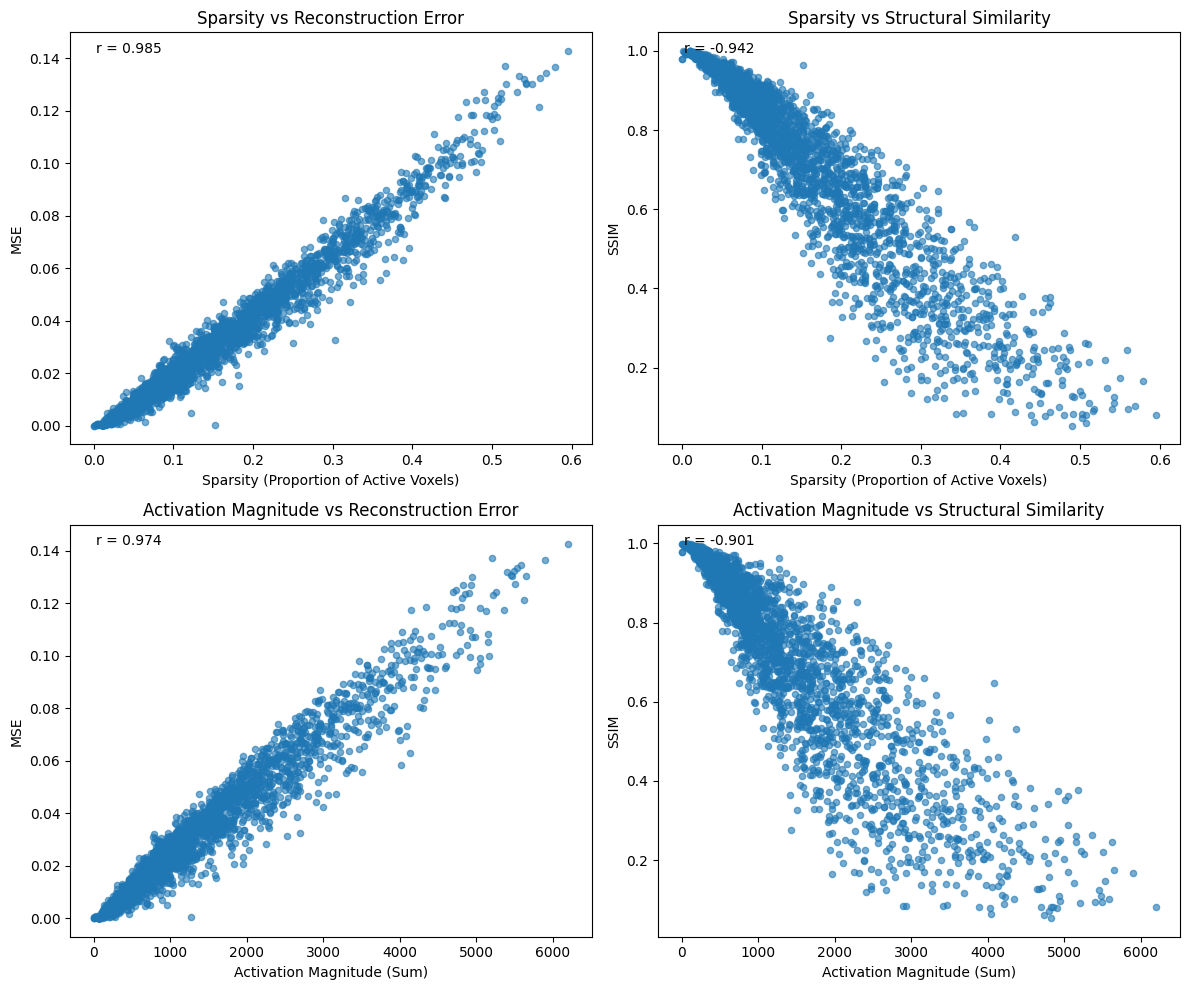

In [ ]:
# Correlation of sparsity and recon quality with MSE and SSIM

val_data = reconstructions['val']
val_metrics = metrics['val']

sparsity = (val_data['original'] > 0).sum(dim=1).float() / val_data['original'].shape[1]

magnitude = val_data['original'].sum(dim=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Sparsity vs MSE
axes[0, 0].scatter(sparsity, val_metrics['mse'], alpha=0.6, s=20)
axes[0, 0].set_xlabel('Sparsity (Proportion of Active Voxels)')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('Sparsity vs Reconstruction Error')
correlation = np.corrcoef(sparsity, val_metrics['mse'])[0, 1]
axes[0, 0].text(0.05, 0.95, f'r = {correlation:.3f}', transform=axes[0, 0].transAxes)

# Sparsity vs SSIM
axes[0, 1].scatter(sparsity, val_metrics['ssim'], alpha=0.6, s=20)
axes[0, 1].set_xlabel('Sparsity (Proportion of Active Voxels)')
axes[0, 1].set_ylabel('SSIM')
axes[0, 1].set_title('Sparsity vs Structural Similarity')
correlation = np.corrcoef(sparsity, val_metrics['ssim'])[0, 1]
axes[0, 1].text(0.05, 0.95, f'r = {correlation:.3f}', transform=axes[0, 1].transAxes)

# Magnitude vs MSE
axes[1, 0].scatter(magnitude, val_metrics['mse'], alpha=0.6, s=20)
axes[1, 0].set_xlabel('Activation Magnitude (Sum)')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Activation Magnitude vs Reconstruction Error')
correlation = np.corrcoef(magnitude, val_metrics['mse'])[0, 1]
axes[1, 0].text(0.05, 0.95, f'r = {correlation:.3f}', transform=axes[1, 0].transAxes)

# Magnitude vs SSIM
axes[1, 1].scatter(magnitude, val_metrics['ssim'], alpha=0.6, s=20)
axes[1, 1].set_xlabel('Activation Magnitude (Sum)')
axes[1, 1].set_ylabel('SSIM')
axes[1, 1].set_title('Activation Magnitude vs Structural Similarity')
correlation = np.corrcoef(magnitude, val_metrics['ssim'])[0, 1]
axes[1, 1].text(0.05, 0.95, f'r = {correlation:.3f}', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

## FPR / TPR

/tmp/ipykernel_1606482/2774601669.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jerjes/repos/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


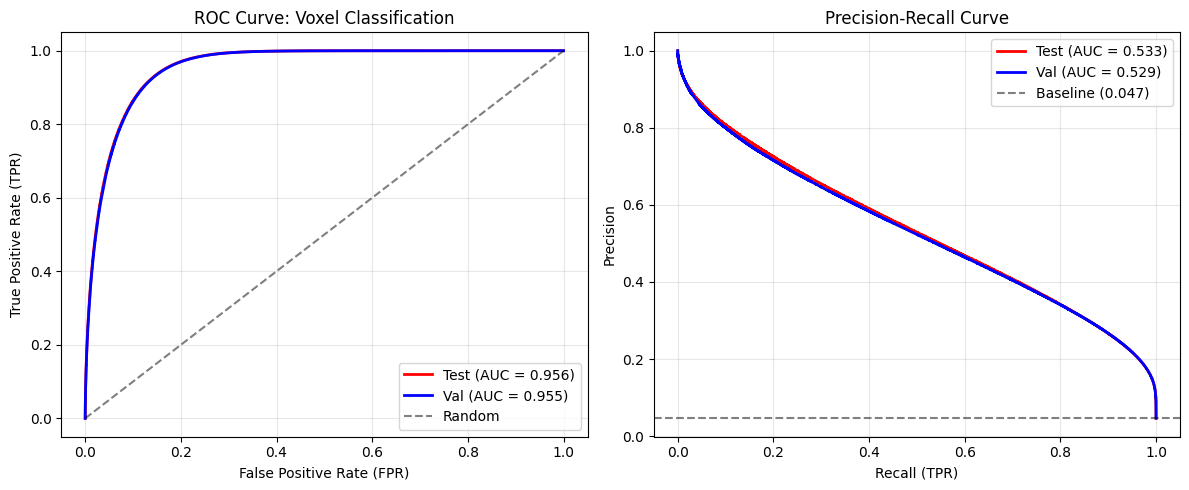


Baseline Information:
  Active voxels: 3,755,813 (4.7%)
  Inactive voxels: 76,447,207 (95.3%)


In [27]:
# Plot ROC and Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = {'val': 'blue', 'test': 'red'}

for split_name, split_results in classification_results.items():
    # Use threshold 0.1 as representative
    result = split_results[0.1]
    color = colors.get(split_name, 'black')
    
    if not np.isnan(result['auc_roc']):
        # ROC Curve
        fpr_curve, tpr_curve, _ = roc_curve(result['y_true'], result['y_scores'])
        axes[0].plot(fpr_curve, tpr_curve, color=color, lw=2, 
                    label=f'{split_name.title()} (AUC = {result["auc_roc"]:.3f})')
        
        # PR Curve  
        precision_curve, recall_curve, _ = precision_recall_curve(result['y_true'], result['y_scores'])
        axes[1].plot(recall_curve, precision_curve, color=color, lw=2,
                    label=f'{split_name.title()} (AUC = {result["auc_pr"]:.3f})')

# Format ROC plot
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0].set_xlabel('False Positive Rate (FPR)')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('ROC Curve: Voxel Classification')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Format PR plot
baseline = result['n_active_voxels'] / result['n_total_voxels']
axes[1].axhline(y=baseline, color='k', linestyle='--', alpha=0.5, 
               label=f'Baseline ({baseline:.3f})')
axes[1].set_xlabel('Recall (TPR)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBaseline Information:")
print(f"  Active voxels: {result['n_active_voxels']:,} ({baseline*100:.1f}%)")
print(f"  Inactive voxels: {result['n_total_voxels'] - result['n_active_voxels']:,} ({(1-baseline)*100:.1f}%)")